In [1]:
# Bleh

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

sns.set()

# Tarefa 4 - Decision Trees, Random Forest and K-Means
Fourth assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados

This tarefa provides an exciting opportunity for students to put their knowledge acquired in class into practice, using decision trees and random forests to solve a real-world problem in classification and delve into the world of unsupervised learning by implementing the K-means algorithm. Students will also get used to generating important plots during training to analyse the models' behaviour. 

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Before submitting your work, make sure to rename the file to the random number that you created for the previous coursework (for example, 289479.ipynb).

## Notebook Overview:

1. [Decision Trees](#Decision_Trees) (30%)
2. [Random Forest](#Random_Forest) (30%)
3. [K-Means](#K-Means) (30%)

### Decision_Trees
## Part 1 - Decision Trees for Classification (value: 30%)

In this exercise, you will implement a decision tree for classifying whether the income of a person exceeds $50k/yr based on census data (adult_census_subset.csv in ECLASS). You will use the Information Gain based on the Gini Index as the impurity measure as the splitting criterion. The maximum depth and the minimum number of instances per leaf will be your stopping criteria. Be aware that some of the variables in this dataset are nominal (or categorical).

To complete this exercise, you will write code to build a decision tree for this problem: 

1. Dataset Splitting:
    - Load the provided dataset into your code.
	- Split the dataset into three sets: training, validation, and testing, with a 70/15/15 ratio, respectively. 
2. Implement a function to learn Decision Trees – the main conceptual steps are detailed below:
	- Initialize an empty decision tree.
	- Implement a recursive function to build the decision tree:
        - The stopping conditions for the recursive function are [note: satisfying only one of them is sufficient to stop the recursion]:
            - If the maximum depth is reached, stop growing the tree and create a leaf node with the frequency of the positive class for the remaining instances.
            - If the number of instances at a leaf node is less than the minimum number of instances per leaf, create a leaf node with the frequency of the positive class for those instances.
        - Your code will calculate the Information Gain (based on the Gini Index) for each possible value of each attribute and choose the attribute and value that maximizes the Information Gain (explanation below).
        - Your code will create a new internal node using the chosen attribute and value.
        - Your code will recursively call the build function on each subset of instances created by the split.
3. Implement a classification function. Implement a function to classify new instances using the decision tree:
	- For each instance, traverse the decision tree by comparing its attribute values to the decision nodes and move down the tree based on the attribute values until a leaf node is reached.
	- Return the frequency of the positive class that is associated with the leaf node as the prediction for the instance.
4. Run your algorithm and evaluate its performance:
	- Call the build function with the training set to construct the decision tree. You will vary the maximum depth and minimum number of instances per leaf to observe their effects on the decision tree performance. You will use the training set to learn the tree and the validation set using the Area Under the Roc Curve (AUROC) to find the optimal parameters. Try only shallow trees of a depth not deeper than 10, and min_instances not smaller than 10. If you try more extreme values, the training time could be too much.
	- Build a decision tree using the training + validation sets with the best combination of parameters.
	- Calculate the accuracy (threshold: 0.5) and AUROC of the decision tree in the testing set and report them.

To select the best split at each node you will use the Information Gain based on the Gini Index. The Gini Index measures the impurity of a node in a decision tree. To calculate the Information Gain based on the Gini Index, follow these steps [note: the same is explained in the slides for the case of entropy]:
- For each potential split (feature and value):
	- Calculate the Gini Index for node m (before any splits) using the class distribution within the node, using the following formula:
        - $G_m=\sum_{k=1}^K (\hat{p}_{mk} (1-\hat{p}_{mk})$, where $\hat{p}_{mk}$ represents the proportion of instances in the node $m$ that belong to class $k$.
	- Calculate the Gini Index for each possible outcome. This involves the following steps:
        - Split the data based on the attribute's possible outcomes.
        - Calculate the Gini index for each resulting subset using the same formula as in step a.
	- Calculate the weighted Gini index by summing up the Gini indexes of each subset, weighted by the proportion of instances it represents in the original node. The formula for the weighted Gini index ($W$) is as follows:
        - $W_V=\sum_v^V \frac{|S_v|}{|S|} G_{S_v} $ where $S_v$ is the node after the split and the sum iterates over all the children nodes; $|S_v|$ represents the cardinality of the node and $|S|$ the cardinality of the node before splitting; $G_{S_v}$ represents the Gini index of the node.
	- Calculate the information gain by subtracting the weighted Gini index obtained in step c. from the Gini index of the current node. The formula is as follows:
        - $InformationGain=G_{node}-W_V$


### Data Splitting

In [23]:
census = pd.read_csv('adult_census_subset.csv')

x, t = census.values[:, :-1], census.values[:, -1]

t = t.astype(int)

x_train, x_temp, t_train, t_temp = train_test_split(x, t, train_size = 0.7)
x_valid, x_test, t_valid, t_test = train_test_split(x_temp, t_temp, train_size = 0.5)

### Decision Tree Class

In [24]:
class DTree():
    """ Decision Tree machine learning model for classification
    """
    def __init__(self) -> None:
        """ Initializing an empty Decision Tree
        """
        self.root = None
        
    def gini_index(self, region):
        """
        Implements the Gini Index criterion in a region
        
        Parameters
        ----------
        region : ndarray
            Array of shape (N,) containing the target values for N datapoints in the training set.
        
        Returns
        -------
        gini : float
            The sum of squared error (= float("inf") for empty regions)
        """
        if region.size == 0: return 0.5 # Returns a bad value if a leaf is empty

        gini = (np.count_nonzero(region)/region.size)*(1-(np.count_nonzero(region)/region.size)) + (np.count_nonzero(region == 0)/region.size)*(1-(np.count_nonzero(region == 0)/region.size))
        return gini
    
    def split_region(self, region, feature_index, tau):
        """
        Given a region, splits it in two based on the passed feature, using tau as threshold
        
        Parameters
        ----------
        region : array of size (n_samples, n_features)
            a partition of the dataset (or the full dataset) to be split
        feature_index : int
            the index of the feature (column of the region array) used to make this partition
        tau : float | int | str
            The threshold used to make the partitions. Can be numeric or nominal.
            
        Return
        ------
        left_partition : array
            indices of the datapoints in `region` where feature < `tau` for numerical features, or feature == `tau` for categorical features
        right_partition : array
            indices of the datapoints in `region` where feature >= `tau` for numerical features, or feature != `tau` for categorical features
        """
        if type(tau) == str:
            mask = region[:, feature_index] == tau # here I create a mask that says True for a line where the "feature_index" column is equal to "tau"
        else:
            mask = region[:, feature_index] < tau # here I create a mask that says True for a line where the "feature_index" column is lower than "tau"

        left_partition = np.nonzero(mask)[0]
        right_partition = np.nonzero(~mask)[0] # Using the logical inverse of the mask
        return left_partition, right_partition

    def get_split(self, X, y):
        """
        Given a dataset (full or partial), splits it on the feature that maximizes the Information Gain based on the Gini Index
        
        Parameters
        ----------
        X : array (n_samples, n_features)
            features 
        y : array (n_samples, )
            target labels
        
        Returns
        -------
        decision : dictionary
            keys if found a good division:
                * 'feature_index' -> an integer that indicates the feature (column) of `X` on which the data is split
                * 'tau' -> the threshold used to make the split
                * 'left_region' -> array of indices where the `feature_index`th feature of X is lower than numeric `tau`, or equal to categoric `tau`
                * 'right_region' -> indices not in `left_region`
            keys if not found a good division:
                * 'value' -> frequency of the positive class for the remaining instances
        """
        Gini_before_split = self.gini_index(y)
        best_gain = 0
        decision = {"value": (np.count_nonzero(y)/y.size)}
    
        for col in range(X.shape[1]):
            for datapoint in range(X.shape[0]):
                tau = X[datapoint, col]
                l, r = self.split_region(X, col, tau)
                
                l_gini = self.gini_index(y[l])
                r_gini = self.gini_index(y[r])

                weighted_gini = ((y[l].size/y.size) * l_gini) + ((y[r].size/y.size) * r_gini) 
                info_gain = Gini_before_split - weighted_gini

                if info_gain > best_gain:
                    best_gain = info_gain
                    decision = {"feature_index": col, "tau": tau, "left_region": l, "right_region": r}

        return decision

    def recursive_growth(self, min_samples, max_depth, X, y, node: dict = None, current_depth = 0):
        """
        Recursively grows itself by optimizing the error in each node and obeying the passed stopping criterions.
        
        Parameters
        ----------
        min_samples : int
            parameter for stopping criterion if a node has <= min_samples datapoints
        max_depth : int
            parameter for stopping criterion if a node belongs to this depth

        X : array (n_samples, n_features)
            features (full dataset)
        y : array (n_samples, )
            labels (full dataset)
        
        node : dictionary, defaults to self.root
            When passed, the recursive growth will start in this node, and not in the root.
            If the passed node is terminal, it contains only the "value" key, which determines the value to be used as a prediction.
            Else, the dictionary has the structure defined by `get_split`.
            
        current_depth : int, defaults to 0
            current distance from the root
        """
        if not node:
            self.root = self.get_split(X, y)
            node = self.root

        if "left_region" in node.keys():
            l = node["left_region"]
            r = node["right_region"]
            
            # Process left
            if (y[l].size <= min_samples) or (current_depth == max_depth):
                node["left"] = {"value": np.count_nonzero(y[l])/y[l].size}
            else:
                node["left"] = self.get_split(X[l], y[l])
                self.recursive_growth(min_samples, max_depth, X, y, node["left"], current_depth+1)   
            
            # Process right
            if (y[r].size <= min_samples) or (current_depth == max_depth):
                node["right"] = {"value": np.count_nonzero(y[r])/y[r].size}
            else:
                node["right"] = self.get_split(X[r], y[r])
                self.recursive_growth(min_samples, max_depth, X, y, node["right"], current_depth+1)

    def print_tree(self, node = None, depth = 0):
        """Prints the whole tree

        :param node: Node from where to start printing, defaults to self.root
        :type node: dict, optional
        :param depth: Current depth of the node, defaults to 0 (root depth)
        :type depth: int, optional
        """
        if not node: 
            node = self.root

        if 'value' in node.keys():
            print('.  '*(depth-1), f"[{node['value']}]")
        else:
            if type(node["tau"]) == str:
                print('.  '*depth, f'X_{node["feature_index"]} == {node["tau"]}')
            else:
                print('.  '*depth, f'X_{node["feature_index"]} < {node["tau"]}')
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)

    def __predict_sample(self, sample, node = None):
        """
        Makes a prediction based on the decision tree defined by `node`
        
        Parameters
        ----------
        sample : array of size (n_features,)
            a sample datapoint to be predicted
        node : dict, defaults to self.root
            A node created by one of the methods above
        """
        if not node: 
            node = self.root

        if "value" in node.keys():
            return node["value"]
        
        if type(node["tau"]) == str:
            if sample[node["feature_index"]] == node["tau"]:
                return self.__predict_sample(sample, node["left"])
        
            return self.__predict_sample(sample, node["right"])
        
        if sample[node["feature_index"]] < node["tau"]:
            return self.__predict_sample(sample, node["left"])
        
        return self.__predict_sample(sample, node["right"])
        
    def predict(self, X):
        """
        Makes a prediction based on the fitted training data
        
        Parameters
        ----------
        X : array of size (n_samples, n_features)
            n_samples predictions will be made

        Returns
        -------
        np.ndarray (n_samples, )
            Unidimensional array with predicted values or labels for each datapoint in the dataset 'X'
        """
        prediction = []
        for datapoint in X:
            prediction.append(self.__predict_sample(datapoint))
        
        return np.array(prediction)


### Finding Parameters

[Text(47.25, 0.5, 'Minimum Samples'),
 Text(0.5, 20.049999999999997, 'Max Depth')]

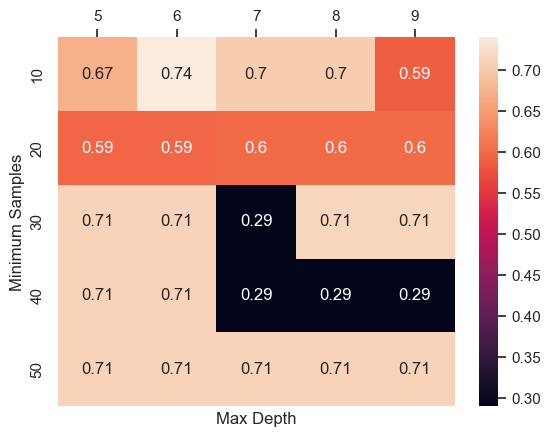

In [25]:
## your code goes here:

min_samples = range(10, 51, 10)
max_depth = range(5, 10)

data = np.zeros((len(min_samples), len(max_depth)))

for samp in range(len(min_samples)):
    for dep in range(len(max_depth)):
        tree = DTree()
        tree.recursive_growth(min_samples[samp], max_depth[dep], x_train, t_train)
        valid_predict = tree.predict(x_valid)
        data[samp,dep] = roc_auc_score(t_valid, valid_predict)

plot_df0 = pd.DataFrame(data, min_samples, max_depth)

ax = sns.heatmap(plot_df0, annot=True)
ax.xaxis.tick_top()
ax.set(ylabel="Minimum Samples", xlabel="Max Depth")

In [26]:
# Picking the optimal parameters
best_tree_score = np.max(data)

best_min_samples = min_samples[np.unravel_index(np.argmax(data), data.shape)[0]]
best_max_depht = max_depth[np.unravel_index(np.argmax(data), data.shape)[1]]

### Testing the Implementation

In [27]:
x_final = np.vstack((x_train, x_valid))
t_final = np.hstack((t_train, t_valid))

final_tree = DTree()
final_tree.recursive_growth(best_min_samples, best_max_depht, x_final, t_final)

test_prob = final_tree.predict(x_test)
tree_rocauc = roc_auc_score(t_test, test_prob)

test_pred = np.zeros(test_prob.shape)
test_pred[test_prob >= 0.5] = 1

tree_accuracy = accuracy_score(t_test, test_pred)
tree_f1 = f1_score(t_test, test_pred)
tree_precision = precision_score(t_test, test_pred)
tree_recall = recall_score(t_test, test_pred)

print(f"Final Stats:\nROCAUC Score = {tree_rocauc}\nAccuracy Score = {tree_accuracy}")

Final Stats:
ROCAUC Score = 0.6945454545454546
Accuracy Score = 0.6593406593406593


## Random_Forest
## Part 2 - Random Forest for Classification Networks (value: 30%)

In this exercise, you will expand on the previous exercise and implement Random Forests. You will build an ensemble of decision trees and use them for the same classification task from Part 1. The dataset used for this exercise will be the same as in the previous exercise. Your task is to write code to construct a Random Forest model, evaluate its performance, and compare it to the decision tree implementation. 

To complete this exercise, you will write code to implement Random Forest for this problem: 

1. Dataset Splitting: use the same splits you used for Part 1.
2. Implement a function to learn Random Forest – the main steps are detailed below:
	- Initialize an empty Random Forest.
	- Determine the number of decision trees to include in the forest (e.g. 20), and the number of the random features to consider, generally `num_features` $≈\sqrt{p}$ where $p$ is the total number of features.
	- Implement a loop to build the specified number of decision trees:
        - Generate a bootstrap sample from the training set (sampling with replacement).
        - Build a decision tree using the bootstrap sample, using your implementation from Part I.
        - Add the constructed decision tree to the Random Forest.
3. Implement a classification function. Implement a function to classify new instances using the Random Forest:
	- For each instance, pass it through all decision trees in the Random Forest and collect the predictions. Note that you should binarize the prediction of each decision tree, that is, use a threshold of 0.5 to determine the actual class label.
	- The prediction for the random forest will be the frequency of the positive class in the predictions collected by all the decision trees.
4. Run your algorithm and evaluate its performance:
	- Call the function to learn the Random Forest with your training set. You will vary the different parameters of the Random Forest to observe their effect on the performance on the validation set. You will use the training set to learn the tree and the validation set using the Area Under the Roc Curve (AUROC) to find the optimal parameters. Again, keep your trees shallow and don’t build many decision trees, as this could delay the training time quite a lot.
	- Build a Random Forest using the training + validation sets with the best combination of parameters.
	- Classify the instances of the testing set using the Random Forest, calculate the accuracy (threshold: 0.5) and Area Under the ROC Curve (AUROC) and report the results.
5. Experimentation: Compare the performance of Random Forests with the single decision tree implementation from the previous exercise reporting the performance on the test set in a table (either a dataframe or the markdown example provided in Lab 12). 


### Random Forest Class

In [28]:
class Random_Forest():
    """ Random Forest machine learning model, implementing classification DTree classes.
    """
    def __init__(self):
        """ Initiating an empty random forest model
        """
        self.x = None
        self.targets = None

        self.bags = None
        self.bagged_features = []

        self.estimators = []

    def fit(self, x_train, y_train):
        """ Fits data into the object's properties

        :param x_train: (n_datapoints, n_features) shaped array containing the dataset
        :type x_train: np.ndarray
        :param y_train: (n_datapoints,) shaped array with target labels
        :type y_train: np.ndarray
        """
        self.x = x_train
        self.targets = y_train

    def bootstrap(self, num_bags=10):
        """ Given a fitted dataset and a number of bags, sample the dataset with replacement.
        This method does not return a copy of the datapoints, but stores in self.bags a list of indices with compatible dimensionality
        
        Parameters
        ----------
        num_bags : int, default 10
            The number of bags to create
        
        Notes
        -----
        * The number of datapoints in each bach will match the number of datapoints in the fitted dataset.
        """
        rng = np.random.default_rng(42) # you can change the seed, or use 0 to replicate my results
        self.bags = [rng.integers(0, self.x.shape[0], self.x.shape[0]) for i in range(num_bags)] 
        
    def __get_features_set(self, feat_num, chosen_num):
        """ Chooses a subset of features between the total number

        :param feat_num: Original number of features
        :type feat_num: int
        :param chosen_num: Number of features to be chosen between the original ones
        :type chosen_num: int

        :return: List of indexes to access a subset of the features
        :rtype: list
        """
        chosen_feats = random.choices(range(feat_num), k = chosen_num)
        return chosen_feats

    def fit_bagging(self, X, y: np.ndarray, num_features, num_estimators, min_samples, max_depht):
        """ Trains a random forest model with 'num_estimators' trees, each trained with a subset of 'num_features' features between the original ones in the dataset 'X'

        :param X: Full dataset to fit in the random forest's trees
        :type X: np.ndarray
        :param y: Full dataset labels
        :type y: np.ndarray

        :param num_features: Number of features to use in each singular tree
        :type num_features: int
        :param num_estimators: Number of trees in the random forest
        :type num_estimators: int
        :param min_samples: Parameter for a tree's stopping criterion if a node has <= min_samples datapoints
        :type min_samples: int
        :param max_depht: Parameter for a tree's stopping criterion if a node belongs to this depth
        :type max_depht: int
        """
        self.estimators.clear()
        self.bagged_features.clear()
        total_features = X.shape[1]

        if y.ndim == 2: # Just a precaution, if y is passed as a bidimensional array
            y = y.reshape(-1)

        self.fit(X, y) # Fits the dataset
        self.bootstrap(num_estimators) # Generate bags

        for i in range(num_estimators):
            estimator = DTree()

            # Separating a subset with fewer features and the same amount of datapoints (random with replacement)
            features = self.__get_features_set(total_features, num_features)
            self.bagged_features.append(features)

            X_subset = X[self.bags[i]][:, features]
            y_subset = y[self.bags[i]]
            
            # Training the tree with the defined subsets of data
            estimator.recursive_growth(min_samples, max_depht, X_subset, y_subset)

            self.estimators.append(estimator)

    def __aggregate_regression(self, preds):
        """ Aggregate predictions by several estimators
        
        Parameters
        ----------
        preds : list of ndarray
            Predictions from multiple estimators.
            All ndarrays in this list should have the same dimensionality.
            
        Return
        ------
        ndarray
            The mean of the predictions
        """
        return np.mean(np.array(preds), 0)

    def predict(self, X):
        """Makes the prediction for a Random Forest Model

        :param estimators: List with many DTree class estimators
        :type estimators: list[DTree]
        :param X: Dataset to predict the labels
        :type X: np.ndarray
        :return: Returns an array with the average from all the predictions in the random forest
        :rtype: np.ndarray
        """
        predictions = []

        for i in range(len(self.estimators)):
            tree = self.estimators[i]
            feats = self.bagged_features[i]

            probs = tree.predict(X[:, feats])
            pred = np.zeros(probs.shape)
            pred[probs >= 0.5] = 1
            
            predictions.append(pred)
        
        return self.__aggregate_regression(predictions)

### Finding Ideal Parameters

In [29]:
numbers_feat = range(2, 7)
numbers_estim = range(10, 51, 10)
data2 = np.zeros((len(numbers_feat), len(numbers_estim)))

for feat in range(len(numbers_feat)):
    for est in range(len(numbers_estim)):
        forest = Random_Forest()
        forest.fit_bagging(x_train, t_train, numbers_feat[feat], numbers_estim[est], best_min_samples, best_max_depht)
        
        y_pred = forest.predict(x_valid)
        data2[feat, est] = roc_auc_score(t_valid, y_pred)

plot_df1 = pd.DataFrame(data2, numbers_feat, numbers_estim)

ax = sns.heatmap(plot_df1, annot=True)
ax.xaxis.tick_top()
ax.set(ylabel="Number of Features", xlabel="Number of Trees")

# Around 3 minutes to run this cell

KeyboardInterrupt: 

In [ ]:
# Picking best parameters
best_num_feats = numbers_feat[np.unravel_index(np.argmax(data2), data2.shape)[0]]
best_num_trees = numbers_estim[np.unravel_index(np.argmax(data2), data2.shape)[1]]

[Text(47.25, 0.5, 'Minimum Samples'),
 Text(0.5, 20.049999999999997, 'Max Depth')]

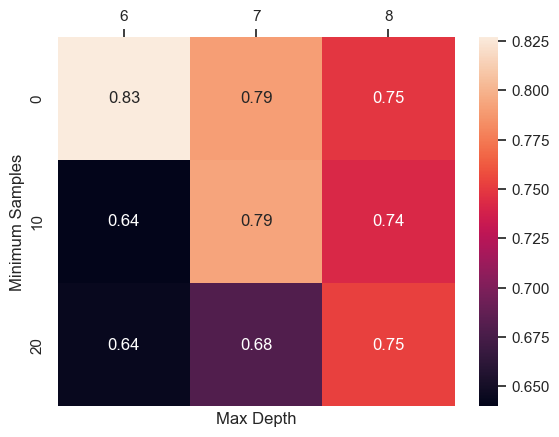

In [ ]:
# We can still try for different tree parameters
min_samples = [best_min_samples-10, best_min_samples, best_min_samples+10]
max_depth = [best_max_depht-1, best_max_depht, best_max_depht+1]

data3 = np.zeros((len(min_samples), len(max_depth)))

for samp in range(len(min_samples)):
    for dep in range(len(max_depth)):
        forest = Random_Forest()
        forest.fit_bagging(x_train, t_train, best_num_feats, best_num_trees, min_samples[samp], max_depth[dep])
    
        y_pred = forest.predict(x_valid)
        data3[samp, dep] = roc_auc_score(t_valid, y_pred)

plot_df3 = pd.DataFrame(data3, min_samples, max_depth)

ax = sns.heatmap(plot_df3, annot=True)
ax.xaxis.tick_top()
ax.set(ylabel="Minimum Samples", xlabel="Max Depth")

In [ ]:
# Picking again the optimal parameters
best_forest_score = np.max(data3)

best_min_samples = min_samples[np.unravel_index(np.argmax(data3), data3.shape)[0]]
best_max_depht = max_depth[np.unravel_index(np.argmax(data3), data3.shape)[1]]

### Testing Implementation

In [ ]:
final_forest = Random_Forest()
final_forest.fit_bagging(x_final, t_final, best_num_feats, best_num_trees, best_min_samples, best_max_depht)

test_prob = final_forest.predict(x_test)

test_pred = np.zeros(test_prob.shape)
test_pred[test_prob >= 0.5] = 1

forest_rocauc = roc_auc_score(t_test, test_prob)
forest_accuracy = accuracy_score(t_test, test_pred)
forest_precision = precision_score(t_test, test_pred)
forest_recall = recall_score(t_test, test_pred)
forest_f1 = f1_score(t_test, test_pred)

print(f"Final Stats:\nROCAUC Score = {forest_rocauc}\nAccuracy Score = {forest_accuracy}")

Final Stats:
ROCAUC Score = 0.8573770491803279
Accuracy Score = 0.6703296703296703


c:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df = pd.DataFrame([[tree_rocauc, tree_accuracy, tree_f1, tree_precision, tree_recall], 
                   [forest_rocauc, forest_accuracy, forest_f1, forest_precision, forest_recall]],
                   ["Decision Tree", "Random Forest"], ["ROCAUC", "Accuracy", "F1 Score", "Precision", "Recall"])

## Comparing the Models

In [ ]:
df # Sometimes it is impossible to calculate F1 Score, Precision and Recall for the Random Forest, and I don't really know why

,ROCAUC,Accuracy,F1 Score,Precision,Recall
Decision Tree,0.538251,0.615385,0.054054,0.142857,0.033333
Random Forest,0.857377,0.670330,0.000000,0.000000,0.000000


## K-Means
## Part 3 – Clustering with K-means (value: 40%)

In this exercise, you will explore clustering by implementing the K-means algorithm. You will write code to perform K-means clustering while visualizing the movement of the centroids at each iteration. 

To complete this exercise, you will write code to implement K-means for clustering: 

1. Dataset Preparation: Run the cells provided in the notebook that generate the artificial data points for this exercise.
2. K-means Clustering:
	- Initialize K cluster centroids by selecting K points from your dataset at random.
	- Implement a loop to perform the following steps until convergence (or until a specified maximum number of iterations is reached, e.g., 150):
        - Assign each data point to the nearest centroid (you will have to calculate the Euclidean distance between the data point and each centroid).
        - Update each centroid by moving it to the mean of all data points assigned to it.
        - Check for convergence by comparing the new centroids with the previous centroids. If the difference is smaller than an $\epsilon=1^{-4}$, exit the loop.
3. Centroid Movement Visualization:
	- At 5 different moments during training, plot a figure showing the centroids and the points. Figure 1 should show the situation at the beginning, before learning. Figure 5 should show the situation at the end of the learning. The remaining Figures 2-4 should show intermediary situations.
	- For each figure, each centroid will be represented by a large black cross and each cluster with a different colour, the points must be coloured according to their respective cluster.
4. Sum of squared distances:
	- Along with plotting the centroid movement, calculate the sum of squared distances at each iteration as follows:
        - $\sum_{j=1}^K \sum_{n \in S_j}d(x_n,\mu_j )^2$, where $K$ is the number of clusters, $x_n$ represents the $n^{th}$ datapoint, $n \in S_j$ indicates a set of points that belong to cluster $S_j$, $\mu_j$ is the mean of the datapoints in $S_j$ and $d(x_n,\mu_j)$ indicates the Euclidean distance between $x_n$ and $\mu_j$.
	- Make a plot of the sum of squared distances at each iteration. 


In [ ]:
# Generate artificial data points
np.random.seed(13)
num_samples = 200
num_features = 2
X = np.random.randn(num_samples, num_features) * 1.5 + np.array([[2, 2]])
X = np.concatenate([X, np.random.randn(num_samples, num_features) * 3 + np.array([[-5, -5]])])
X = np.concatenate([X, np.random.randn(num_samples, num_features) * 2 + np.array([[7, -5]])])

In [ ]:
class K_Means():
    """Class for storing clusters created through the k-means method.
    """
    def __init__(self):
        """Initialize an empty K_Means class.
        """
        self.points = None
        self.labels = None

        self.n_clusters = None
        self.centroids = None

        self.ss_distances = []

    def euclid_distance(self, x1, x2):
        """Calculates the euclidean distance between the points in x1 and x2.
        x1 and x2 can be unidimensional or bidimensional, and must have the same shapes.

        :param x1: First array of points with shape (n_coordinates,) or (n_points, n_coordinates)
        :type x1: np.ndarray
        :param x2: Second array of points with shape (n_coordinates,) or (n_points, n_coordinates)
        :type x2: np.ndarray

        :return: Euclidean distance between the passed points. Will be an int if x1 and x2 are unidimensional, or an array if x1 and x2 are bidimensional.
        :rtype: int | np.ndarray
        """
        return np.sqrt(np.sum((x1 - x2)**2, -1))

    def assign_points(self):
        """Assign points to a cluster according to the nearest centroid. Stores in self.labels an array (n_points,) with the points' respective labels.
        """
        predict = [] 

        for point in self.points:
            best_distance = float("inf") # Starting the distance for the loop

            for i in range(len(self.centroids)): # Search for the nearest centroid
                distance = self.euclid_distance(point, self.centroids[i])

                if distance < best_distance: # If this cluster's centroid is nearer than the best found until now, assign it as the new best
                    best_distance = distance
                    label = i
            
            predict.append(label)

        self.labels = np.array(predict)

    def find_centroids(self):
        """Auxiliar method for the K_Means class. Assigns to the self.centroids property an array (n_clusters, n_coordinates) with points correspondent to the mass centers of the clusters.
        """
        self.centroids = []
        for i in range(self.n_clusters): 
            self.centroids.append(np.mean(self.points[self.labels == i], 0))
        
        self.centroids = np.array(self.centroids)

    def plot_points(self, title = None):
        """Plot a scatterplot with the points and the centroids currently fitted in the class

        :param title: Title of the plot, defaults to None
        :type title: str, optional
        """
        fig, ax = plt.subplots()
        fig.suptitle(title)
        sns.scatterplot(x = self.points[:,0], y = self.points[:,1], hue = self.labels, palette = sns.color_palette("tab10", self.n_clusters))
        sns.scatterplot(x = self.centroids[:,0], y = self.centroids[:, 1], s = 50, marker = "X", color="black")

    def create_clusters(self, points, k, max_iter, eps):
        """Creates 'k' clusters among the points passed through the k_means method, and returns a vector with labels for each point.
        Plots 5 Scatterplots illustrating the clusters through different colors, with their centers represented as crosses.
        Also plots the evolution of the Sum of Squared Distances through the iterations.

        :param points: Array with points to be clustered.
        :type points: np.ndarray
        :param k: Number of clusters to create.
        :type k: int
        :param max_iter: Stopping condition: number of maximum iterations.
        :type max_iter: int
        :param eps: Stopping condition: will stop the iteration if the convergence in an iteration is smaller than 'eps'.
        :type eps: float
        
        :return: Prediction array shaped (n_points,) with labels for all the points according to their respective cluster, from 0 to 'k-1'. 
        :rtype: np.ndarray
        """
        self.ss_distances.clear() # Empty the list for the Sum of Squared Distances
        
        self.points = points
        self.n_clusters = k

        rng = np.random.default_rng()
        self.centroids = rng.choice(self.points, k, False) # Generating random starting centroids

        # First plot, before any Iterations
        self.assign_points()
        self.plot_points("Initial Random Clusters")

        for i in range(max_iter):
            self.assign_points() # Assigning points to the nearest centroid's cluster

            old_centroids = self.centroids 
            self.find_centroids() # Updating the centroids

            if i < 3: # Making Scatterplots for the 3 first iterations
                self.plot_points(f"Iteration Number {i+1}")

            # Calculating the current Sum of Squared Distances
            square_distances = []
            for j in range(k):
                square_distances.append(np.sum(
                    [self.euclid_distance(xn, self.centroids[j])**2 for xn in points[self.labels == j]]
                    ))
            self.ss_distances.append(np.sum(square_distances)) # Storing the ssd for the final plot

            # Calculating the convergence, and breaking the loop if the stopping condition is achieved
            convergence = np.sum(self.euclid_distance(self.centroids, old_centroids))
            if convergence < eps: break

        # Scatterplot for the final result
        self.plot_points("Last Iteration")
        
        # Plotting the Sum of Square Distances
        fig, ax = plt.subplots()
        fig.suptitle("Sum of Square Distances Evolution over Time")
        sns.lineplot(self.ss_distances)

        return self.labels

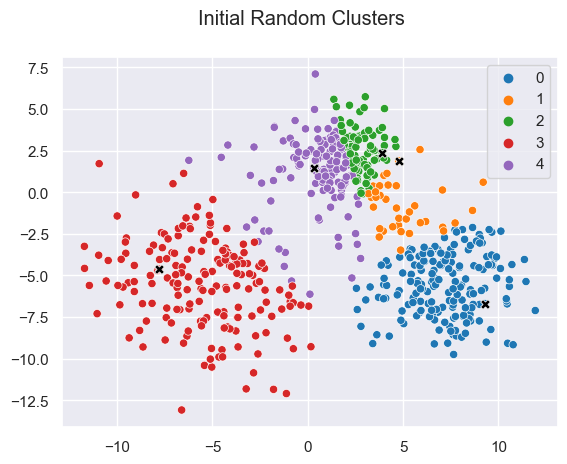

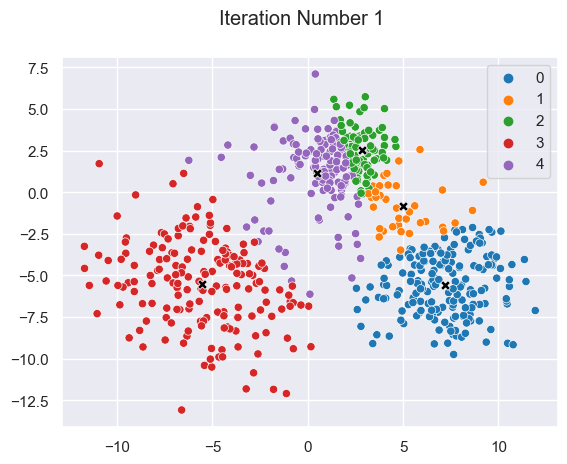

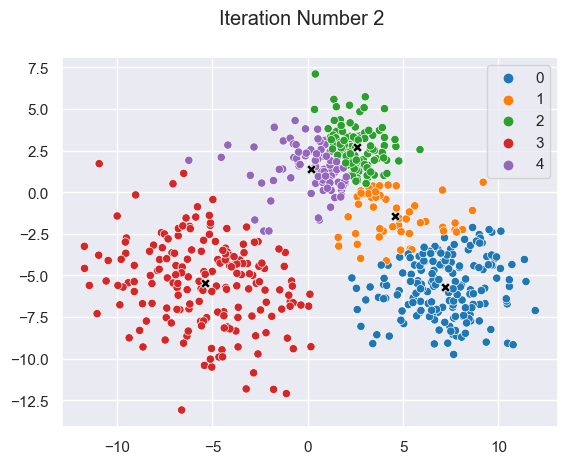

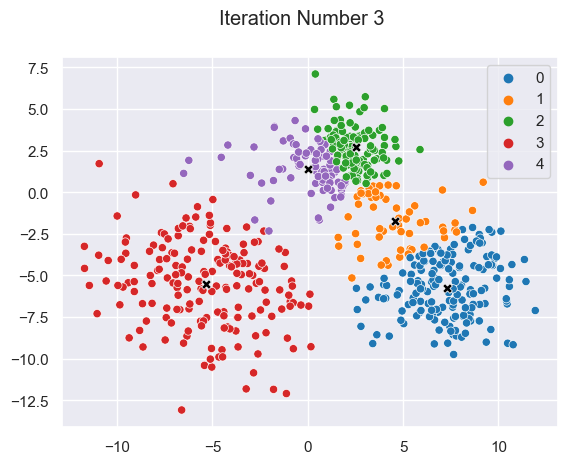

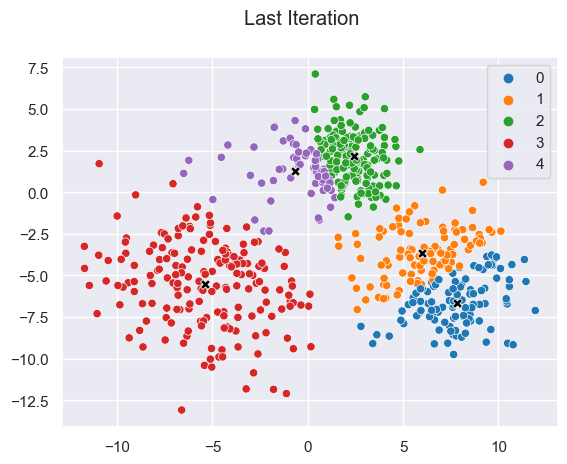

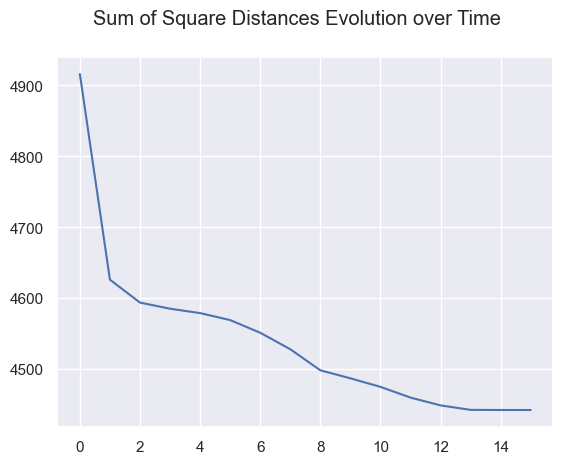

In [ ]:
## your code goes here:
k_m = K_Means()
y_pred = k_m.create_clusters(X, 5, 100, 10**-4)